## Introduction

## Seeds

## 3 Zarr Optimize Algorithm

### 3.1 Description

In [12]:
import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
from scipy import ndimage as ndi
from distributed import LocalCluster
from pyproj import Transformer

In [ ]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51279 instead
  warnings.warn(


LocalCluster(6a42c0fa, 'inproc://10.67.42.116/2716/9', workers=1, threads=16, memory=31.26 GiB)

2025-12-16 15:03:36,939 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2701s; removing: <WorkerState 'inproc://10.67.42.116/2716/12', name: 0, status: running, memory: 0, processing: 0>
2025-12-16 15:03:36,943 - distributed.scheduler - WARNING - Workers ['inproc://10.67.42.116/2716/12'] do not use a nanny and will be terminated without restarting them
2025-12-16 15:03:36,948 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'inproc://10.67.42.116/2716/12'.
2025-12-16 15:03:36,954 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


In [14]:
# Define AOI for Iceland and convert to UTM
spatial_extent = {
    "west":  -24.65,
    "south":  63.30,
    "east":  -13.17,
    "north":  66.58,
}

# BBOX in WGS84 (for STAC search in EPSG:4326)
bbox_4326 = [
    spatial_extent["west"],
    spatial_extent["south"],
    spatial_extent["east"],
    spatial_extent["north"],
]

# Convert AOI to UTM 28N (EPSG:32628) - covers western Iceland
# Sentinel-2 data is stored in UTM zones
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32628", always_xy=True)

west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

print("Iceland BBOX in UTM 28N (EPSG:32628):")
print(f"west_utm: {west_utm:.2f}")
print(f"south_utm: {south_utm:.2f}")
print(f"east_utm: {east_utm:.2f}")
print(f"north_utm: {north_utm:.2f}")

# Spatial slice parameters
x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)

Iceland BBOX in UTM 28N (EPSG:32628):
west_utm: 17595.38
south_utm: 7055428.59
east_utm: 581157.36
north_utm: 7385750.35


## STAC Search

In [15]:
# Connect to the STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-2 L2A items - using 2 weeks for testing
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_4326,
    datetime="2025-11-15/2025-11-30",  # 2 weeks for testing
)

# Retrieve the list of matching items
items = list(search.items())
hrefs = [item.assets["product"].href for item in items]

print(f"Found {len(items)} items")

Found 82 items


In [16]:
print(f"List of Items returned from the STAC query: {items}")
print(f"List of Zarr URLs returned from the STAC query: {hrefs}")

List of Items returned from the STAC query: [<Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T28VDR_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T28VCR_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T27VXL_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T27VWL_20251128T165727>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VWL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VVL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VUL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T26WPS_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T26VPR_20251127T134025>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28WES_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28WDS_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28VER_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28VDR_20251125T131214>, <Item id=S2B_MSIL2A

In [17]:
import warnings
warnings.filterwarnings("ignore", message="Engine 'eopf-zarr' loading failed")


In [23]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

# Load data - select only needed bands
# Note: Skipping spatial subset since Iceland spans multiple UTM zones
datacube_20 = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r20m",     
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)

datacube_20 = datacube_20[["b03", "b11"]]
print(f"Datacube shape: time={len(datacube_20.time)}, y={len(datacube_20.y)}, x={len(datacube_20.x)}")
datacube_20

C:\Users\justi\AppData\Local\Temp\ipykernel_2716\13449087.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  datacube_20 = xr.open_mfdataset(
C:\Users\justi\AppData\Local\Temp\ipykernel_2716\13449087.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  datacube_20 = xr.open_mfdataset(
C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\dask\array\core.py:499

Datacube shape: time=82, y=20490, x=20490


<xarray.Dataset> Size: 551GB
Dimensions:  (time: 82, y: 20490, x: 20490)
Coordinates:
  * time     (time) datetime64[ns] 656B 2025-11-15T12:32:59 ... 2025-11-28T12...
  * y        (y) float32 82kB 6.99e+06 6.99e+06 6.99e+06 ... 7.4e+06 7.4e+06
  * x        (x) float32 82kB 3e+05 3e+05 3e+05 ... 7.098e+05 7.098e+05
Data variables:
    b03      (time, y, x) float64 275GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b11      (time, y, x) float64 275GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [ ]:
# Load SCL (Scene Classification Layer)
scl = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)[["scl"]]

# Interpolate SCL to match datacube_20 grid and add to dataset
scl_resampled = scl.scl.interp_like(datacube_20, method="nearest")
datacube_20["scl"] = scl_resampled

# Compute to load into memory
datacube_20 = datacube_20.compute()
datacube_20

C:\Users\justi\AppData\Local\Temp\ipykernel_2716\3749475497.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  scl = xr.open_mfdataset(
C:\Users\justi\AppData\Local\Temp\ipykernel_2716\3749475497.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  scl = xr.open_mfdataset(
C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\dask\array\core.py:4997: Performance

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

: 

## NDSI Calculation

Calculate the Normalized Difference Snow Index (NDSI) using Band 3 (green) and Band 11 (SWIR):

$$NDSI = \frac{B03 - B11}{B03 + B11}$$

NDSI values close to 1 indicate snow/ice, while values close to -1 indicate non-snow surfaces.

In [ ]:
def compute_ndsi(ds: xr.Dataset) -> xr.DataArray:
    """
    Compute NDSI (Normalized Difference Snow Index) from Sentinel-2 bands.
    NDSI = (B03 - B11) / (B03 + B11)
    """
    green = ds["b03"].astype("float32")
    swir = ds["b11"].astype("float32")
    
    numerator = green - swir
    denominator = green + swir
    
    ndsi = xr.where(denominator != 0, numerator / denominator, np.nan)
    ndsi.name = "NDSI"
    
    return ndsi


# Calculate NDSI
ndsi_dataset = compute_ndsi(datacube_20)
ndsi_dataset

<xarray.DataArray 'NDSI' (time: 84, y: 0, x: 0)> Size: 0B
array([], shape=(84, 0, 0), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 672B 2025-11-15T12:32:59 ... 2025-12-01T12...
  * y        (y) float32 0B 
  * x        (x) float32 0B 


<xarray.DataArray 'NDSI' (time: 84, y: 0, x: 0)> Size: 0B
array([], shape=(84, 0, 0), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 672B 2025-11-15T12:32:59 ... 2025-12-01T12...
  * y        (y) float32 0B 
  * x        (x) float32 0B

### NDSI Time Series Analysis

TypeError: No numeric data to plot.

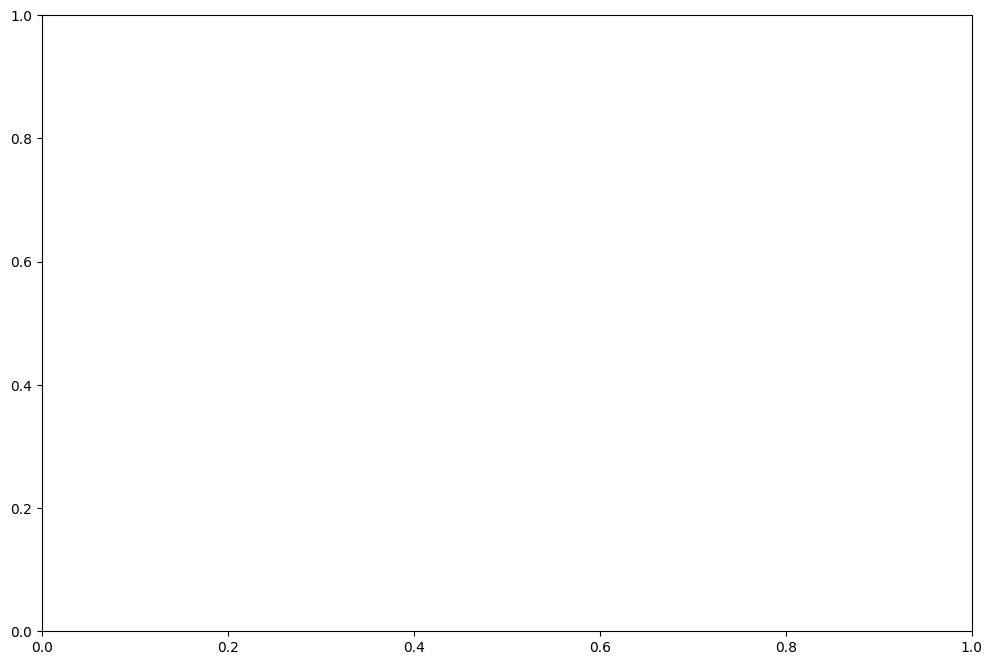

In [ ]:
# Calculate mean and std across spatial dimensions
mean_ndsi = ndsi_dataset.mean(dim=["x", "y"]).to_series()
std_ndsi = ndsi_dataset.std(dim=["x", "y"]).to_series()

# Create time series dataframe
ndsi_timeseries = pd.concat([mean_ndsi, std_ndsi], axis=1).dropna()
ndsi_timeseries.columns = ["Mean NDSI", "SD"]
ndsi_timeseries.index = pd.to_datetime(ndsi_timeseries.index)
ndsi_timeseries = ndsi_timeseries.sort_index()

# Plot time series
plt.figure(figsize=(14, 6))
plt.plot(ndsi_timeseries["Mean NDSI"], "o-", label="Mean NDSI")
plt.fill_between(
    ndsi_timeseries.index,
    ndsi_timeseries["Mean NDSI"] - ndsi_timeseries["SD"],
    ndsi_timeseries["Mean NDSI"] + ndsi_timeseries["SD"],
    color="gray",
    alpha=0.2,
    label="±1 SD"
)
plt.axhline(y=0.4, color="red", linestyle="--", label="Snow threshold (NDSI=0.4)")
plt.ylim(-1, 1)
plt.xlabel("Date")
plt.ylabel("NDSI")
plt.title("Iceland - Mean NDSI Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNDSI Statistics:")
print(f"Mean: {ndsi_timeseries['Mean NDSI'].mean():.3f}")
print(f"Max: {ndsi_timeseries['Mean NDSI'].max():.3f}")
print(f"Min: {ndsi_timeseries['Mean NDSI'].min():.3f}")

The idea of this algorithm is to exploit the chunking of the cloud-native Zarr format in order to load only those parts of the Sentinel-2 scenes that are actually needed.

1. **Load Seeds**: We load glacier seed points via a GeoJSON.
2. **Create Grid**: Then we create a 10 km × 10 km grid (EPSG:5325) that covers the whole of Iceland and mark every grid cell as a *candidate* that contains at least one seed point.  
3. **Query STAC**: For each *candidate* 10 km × 10 km cell, we query the Sentinel-2 L2A collection via [STAC](https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items) to find all scenes in the given time period whose footprint intersects the cell.  
4. **Load Zarr Data**: For each scene, we load only the relevant data chunks from the Zarr store:
   - Transform cell bounds from ISN2004 to the scene's UTM zone
   - Extract B03 (Green, 10m) and B11 (SWIR1, 20m) bands
   - Apply Scene Classification Layer (SCL) quality mask to remove clouds, shadows, and water  
5. **Compute Median NDSI**: From all loaded scenes (across all tiles), we:
   - Resample B11 from 20m to 10m resolution
   - Calculate NDSI = (B03 - B11) / (B03 + B11) for each scene
   - Reproject all NDSI arrays to common ISN2004 grid (10m resolution)
   - Compute temporal median to reduce noise and cloud contamination.
   - Every pixel with NDSI ≥ 0.42 is classified as snow/ice.  
7. **Spatial Expansion**: If more than 30% of the pixels within a *candidate* cell are classified as snow/ice, all 4 neighboring cells (that have not yet been processed) are also marked as *candidate* cells.
8. **Iterate**: The algorithm repeats steps 3 to 7 until no additional *candidate* cells remain.

### 3.2 Implementation

#### 3.2.1 Step 0: Imports and Configuration

In [3]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import box, Point
import pyproj
from pyproj import Transformer

# Data processing
import xarray as xr
import numpy as np
import pandas as pd
import dask.array
import rioxarray  # For CRS handling and reprojection
from rasterio.transform import from_bounds

# STAC API for Sentinel-2 data
from pystac_client import Client

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
from folium import plugins

# Global Configuration Variables
EPSG_ICELAND = 5325  # ISN2004 / Lambert 2004 (Iceland's national projection)
BOUNDING_BOX_ICELAND = [1400000, 100000, 2000000, 500000]  # [minx, miny, maxx, maxy] in ISN2004
GRID_SIZE = 10000  # Grid cell size: 10 km in meters
NDSI_THRESHOLD = 0.42  # Snow/ice classification threshold (NDSI >= 0.42)
SNOW_PERCENTAGE_THRESHOLD = 0.30  # Spatial expansion threshold (30% snow coverage)
STAC_URL = "https://stac.core.eopf.eodc.eu"  # EOPF STAC Catalog endpoint

# Time period configuration
DATE_START = "2025-07-01"  # Start date for Sentinel-2 data query (YYYY-MM-DD)
DATE_END = "2025-07-31"    # End date for Sentinel-2 data query (YYYY-MM-DD)

# For devoloping
MAX_ITERATIONS = 50  # Maximum number of iterations for the spatial expansion algorithm

#### 3.2.2 Step 1: Load and Visualize Seeds

**Goal**: Load glacier seed points that mark known glacier locations across Iceland.

- Display statistics and create interactive map with satellite imagery background

**Input**: `data/Iceland_Seeds_203.geojson` (203 glacier seed points from CORINE Land Cover) - Transform to ISN2004 coordinate system if necessary

- Load seed points from GeoJSON file

**Output**: GeoDataFrame with seed points in EPSG:5325 (ISN2004)


In [49]:
# Load seeds
seeds = gpd.read_file('data/Iceland_Seeds_big.geojson')

# Check CRS and transform to ISN2004 if necessary
print(f"Original CRS: {seeds.crs}")
if seeds.crs.to_epsg() != EPSG_ICELAND:
    seeds = seeds.to_crs(epsg=EPSG_ICELAND)
    print(f"Transformed to EPSG:{EPSG_ICELAND}")

# Overview of the seeds
print(f"\nNumber of seed points: {len(seeds)}")
print(f"\nFirst 3 seeds:")
print(seeds.head(3))

# Get bounds of the seeds
bounds = seeds.total_bounds
print(f"\nBounding box of seeds (EPSG:{EPSG_ICELAND}):")
print(f"   X: [{bounds[0]:.0f}, {bounds[2]:.0f}]")
print(f"   Y: [{bounds[1]:.0f}, {bounds[3]:.0f}]")

Original CRS: EPSG:5325

Number of seed points: 1

First 3 seeds:
   fid                        geometry
0   13  POINT (1810583.059 237169.343)

Bounding box of seeds (EPSG:5325):
   X: [1810583, 1810583]
   Y: [237169, 237169]


Visualization of seed points:

In [50]:
# Interactive visualization of the seeds with satellite imagery
seeds_wgs84 = seeds.to_crs(epsg=4326)  # WGS84 for web maps

# Calculate center of Iceland for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_seeds = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_seeds)

# Add seed points to map
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.5,
        popup=f"Seed {idx}",
        tooltip="Glacier Seed"
    ).add_to(map_seeds)

# Add layer control
folium.LayerControl().add_to(map_seeds)

print(f"Step 1 completed: {len(seeds)} seeds loaded and visualized")
print("Interactive map created with satellite imagery background")

# Display map
map_seeds

Step 1 completed: 1 seeds loaded and visualized
Interactive map created with satellite imagery background


#### 3.2.3 Step 2: Create Grid and Mark Candidates

**Goal**: Create a regular grid covering Iceland and identify candidate cells for processing.

- Mark cells with seeds as initial candidates for processing

**Input**: Spatial join to identify which cells contain seed points

- `BOUNDING_BOX_ICELAND`: Extent of Iceland in ISN2004 coordinates- Generate regular grid covering Iceland's bounding box

- `GRID_SIZE`: Cell size (10,000 m = 10 km)

- Seeds from Step 1

In [61]:
def create_grid(bounds, grid_size):
    """
    Creates a regular grid with the given cell size and bounding box.
    
    Parameters:
    -----------
    bounds : tuple
        (xmin, ymin, xmax, ymax) in meters
    grid_size : int
        Size of a grid cell in meters
        
    Returns:
    --------
    gpd.GeoDataFrame with columns:
        - cell_id: Unique identifier for each cell
        - geometry: Polygon representing the cell boundary
    """
    xmin, ymin, xmax, ymax = bounds
    
    # Round the grid boundaries to multiples of grid_size
    xmin = np.floor(xmin / grid_size) * grid_size
    ymin = np.floor(ymin / grid_size) * grid_size
    xmax = np.ceil(xmax / grid_size) * grid_size
    ymax = np.ceil(ymax / grid_size) * grid_size
    
    # Create grid cells
    grid_cells = []
    grid_ids = []
    cell_id = 0
    
    y = ymin
    while y < ymax:
        x = xmin
        while x < xmax:
            # Create a square polygon for each grid cell
            cell = box(x, y, x + grid_size, y + grid_size)
            grid_cells.append(cell)
            grid_ids.append(cell_id)
            cell_id += 1
            x += grid_size
        y += grid_size
    
    # Create GeoDataFrame
    grid = gpd.GeoDataFrame({
        'cell_id': grid_ids,
        'geometry': grid_cells
    }, crs=f"EPSG:{EPSG_ICELAND}")
    
    return grid

# Create grid
grid = create_grid(BOUNDING_BOX_ICELAND, GRID_SIZE)

print(f"Grid created:")
print(f"Number of grid cells: {len(grid)}")
print(f"Cell size: {GRID_SIZE/1000} km × {GRID_SIZE/1000} km")

Grid created:
Number of grid cells: 2400
Cell size: 10.0 km × 10.0 km


Now we mark every cell, which contains a seed, as a candidate

In [62]:
# Mark grid cells with seeds as candidates
def mark_candidate_cells(grid, seeds):
    """
    Marks grid cells that contain at least one seed point as candidates for processing.
    
    Uses spatial join to identify which grid cells intersect with seed points.
    Only cells containing seeds are marked as initial candidates.
    
    Parameters:
    -----------
    grid : gpd.GeoDataFrame
        GeoDataFrame with grid cells (from create_grid)
    seeds : gpd.GeoDataFrame
        GeoDataFrame with seed points (glacier locations)
        
    Returns:
    --------
    gpd.GeoDataFrame with additional columns:
        - is_candidate: bool indicating if the cell contains at least one seed
        - seed_count: number of seeds contained in the cell
    """
    # Initialize all cells as non-candidates
    grid['is_candidate'] = False
    grid['seed_count'] = 0
    
    # Spatial join: which grid cells contain which seeds?
    joined = gpd.sjoin(grid, seeds, how='inner', predicate='contains')
    
    # Count seeds per grid cell (only for cells that contain seeds)
    if len(joined) > 0:
        candidate_counts = joined.groupby('cell_id').size()
        
        # Mark cells containing seeds as candidates
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'is_candidate'] = True
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'seed_count'] = \
            grid.loc[grid['cell_id'].isin(candidate_counts.index), 'cell_id'].map(candidate_counts)
    
    return grid

grid = mark_candidate_cells(grid, seeds)

# Statistics
n_candidates = grid['is_candidate'].sum()
print(f"\n Grid statistics:")
print(f"   Total grid cells: {len(grid)}")
print(f"   Candidate cells: {n_candidates}")
print(f"   Seeds per candidate (average): {grid[grid['is_candidate']]['seed_count'].mean():.1f}")


 Grid statistics:
   Total grid cells: 2400
   Candidate cells: 87
   Seeds per candidate (average): 2.3


Then we create an interactive visualization, which displays the Seeds, Grid, candidate cells and a background satellite images:

In [63]:
# Interactive visualization: Grid with candidate cells on satellite imagery
# This creates a layered map showing all grid cells, highlighted candidates, and seed points

# Transform to WGS84 for web mapping (folium requires WGS84)
grid_wgs84 = grid.to_crs(epsg=4326)
candidates_wgs84 = grid_wgs84[grid_wgs84['is_candidate']]
non_candidates_wgs84 = grid_wgs84[~grid_wgs84['is_candidate']]
seeds_wgs84 = seeds.to_crs(epsg=4326)

# Calculate center for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_grid = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_grid)

# Add ALL grid cells
folium.GeoJson(
    non_candidates_wgs84,
    name='All Grid Cells',
    style_function=lambda x: {
        'fillColor': 'lightblue',
        'color': 'lightgray',
        'weight': 0.5,
        'fillOpacity': 0.1,
        'opacity': 0.4
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id'],
        aliases=['Cell ID:'],
        localize=True
    )
).add_to(map_grid)

# Add candidate cells
folium.GeoJson(
    candidates_wgs84[['cell_id', 'seed_count', 'geometry']],
    name='Candidate Cells',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'darkblue',
        'weight': 2.5,
        'fillOpacity': 0.4,
        'opacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Seeds:'],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Number of Seeds:']
    )
).add_to(map_grid)

# Add seed points as feature group
seed_group = folium.FeatureGroup(name='Glacier Seeds')
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        popup=f"<b>Seed {idx}</b>",
        tooltip="Glacier Seed"
    ).add_to(seed_group)

seed_group.add_to(map_grid)

# Add fullscreen button
plugins.Fullscreen().add_to(map_grid)

# Add layer control (allows toggling layers on/off)
folium.LayerControl(collapsed=False).add_to(map_grid)

print(f"Step 2 completed: Grid with {n_candidates} candidate cells created")
print(f"Interactive map created with {len(grid)} grid cells ({n_candidates} highlighted as candidates)")
print("Tip: Use the layer control in the top right to toggle layers on/off")

# Display map
map_grid

Step 2 completed: Grid with 87 candidate cells created
Interactive map created with 2400 grid cells (87 highlighted as candidates)
Tip: Use the layer control in the top right to toggle layers on/off


#### 3.2.4 Step 3: Query STAC Catalog

**Goal**: Find all Sentinel-2 L2A scenes that cover a candidate cell in the specified time period.

**Input**:
- Candidate cell (with geometry in ISN2004)
- Time period (date_start, date_end)
- `STAC_URL`: EOPF STAC Catalog endpoint

**Output**: List of STAC items (Sentinel-2 L2A scenes) with Zarr data URLs

**Process**:
- Transform cell bounds from ISN2004 to WGS84 (required for STAC API)
- Query EOPF catalog for all Sentinel-2 L2A scenes intersecting the cell- Return all matching scenes (from all tiles)
- Filter by time period

In [64]:
def query_stac_for_cell(cell, date_start, date_end, epsg_code=5325, stac_url=None, verbose=False):
    """
    Query EOPF STAC Catalog for Sentinel-2 L2A scenes covering a grid cell.
    
    This function searches for all Sentinel-2 L2A scenes that intersect with
    the given cell's geometry during the specified time period. It handles
    coordinate transformation from ISN2004 to WGS84 (required by STAC API).
    
    Parameters:
    -----------
    cell : pandas.Series or dict
        Cell with 'geometry' attribute (Shapely polygon in ISN2004)
    date_start : str
        Start date in format "YYYY-MM-DD"
    date_end : str
        End date in format "YYYY-MM-DD"
    epsg_code : int
        EPSG code of input cell geometry (default: 5325 for ISN2004)
    stac_url : str, optional
        STAC catalog URL (default: uses global STAC_URL variable)
    verbose : bool
        If True, print progress information (default: False)
    
    Returns:
    --------
    list : List of STAC items (pystac.Item objects) with Zarr data URLs
    """
    
    # Use global STAC_URL if not provided
    if stac_url is None:
        stac_url = STAC_URL
    
    # Transform cell bounds from ISN2004 to WGS84 (required by STAC API)
    cell_gdf = gpd.GeoDataFrame([cell], crs=f"EPSG:{epsg_code}")
    cell_wgs84 = cell_gdf.to_crs(epsg=4326)  # WGS84 for STAC API
    bbox_wgs84 = cell_wgs84.total_bounds  # (minx, miny, maxx, maxy)
    
    if verbose:
        print(f"Querying STAC catalog for cell ID: {cell.get('cell_id', 'unknown')}")
        print(f"  Time period: {date_start} to {date_end}")
        print(f"  Bounding box (WGS84): [{bbox_wgs84[0]:.4f}, {bbox_wgs84[1]:.4f}, {bbox_wgs84[2]:.4f}, {bbox_wgs84[3]:.4f}]")
    
    # Connect to EOPF STAC Catalog
    catalog = Client.open(stac_url)
    
    # Search for Sentinel-2 L2A scenes that intersect the cell
    # Note: No filtering by tile ID - we accept scenes from ALL tiles
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox_wgs84,
        datetime=[date_start, date_end]
    )
    
    # Collect results
    items = list(search.items())
    
    if verbose:
        print(f"  -> Found {len(items)} scenes") 
    return items

In [65]:
# ======================================================================
# TEST: Query STAC Catalog for a Single Candidate Cell
# ======================================================================
# This cell demonstrates Step 3 by querying the STAC catalog for all
# Sentinel-2 L2A scenes covering a test candidate cell.

print("=" * 70)
print("TESTING STEP 3: Query STAC Catalog")
print("=" * 70)

# Select first candidate cell for testing
# test_cell = grid[grid['is_candidate']].iloc[5]
test_cell = grid[grid['cell_id'] == 1332].iloc[0]

print(f"\nTest candidate cell:")
print(f"  Cell ID: {test_cell['cell_id']}")
print(f"  Seeds: {test_cell['seed_count']}")

# Get cell bounds for display
cell_bounds = test_cell.geometry.bounds  # (minx, miny, maxx, maxy)
print(f"  Bounds (ISN2004): X=[{cell_bounds[0]:.0f}, {cell_bounds[2]:.0f}], Y=[{cell_bounds[1]:.0f}, {cell_bounds[3]:.0f}]")

print(f"\nTime period: {DATE_START} to {DATE_END}\n")

# Execute Step 3: Query STAC catalog using global date variables
items = query_stac_for_cell(
    cell=test_cell,
    date_start=DATE_START,
    date_end=DATE_END,
    epsg_code=EPSG_ICELAND,
    verbose=True
)

print("\n" + "=" * 70)
print("STEP 3 COMPLETED")
print("=" * 70)
print(f"Result: {len(items)} Sentinel-2 L2A scenes found")

if len(items) > 0:
    print(f"\nFirst scene details:")
    first_item = items[0]
    print(f"  ID: {first_item.id}")
    print(f"  Date: {first_item.datetime}")
    print(f"  Cloud cover: {first_item.properties.get('eo:cloud_cover', 'N/A')}%")
    print(f"  EPSG: {first_item.properties.get('proj:epsg', 'N/A')}")
else:
    print("\nWarning: No scenes found. Consider adjusting the time period.")

TESTING STEP 3: Query STAC Catalog

Test candidate cell:
  Cell ID: 1332
  Seeds: 0
  Bounds (ISN2004): X=[1520000, 1530000], Y=[320000, 330000]

Time period: 2025-07-01 to 2025-07-31

Querying STAC catalog for cell ID: 1332
  Time period: 2025-07-01 to 2025-07-31
  Bounding box (WGS84): [-22.8499, 65.1304, -22.6242, 65.2252]


  -> Found 29 scenes

STEP 3 COMPLETED
Result: 29 Sentinel-2 L2A scenes found

First scene details:
  ID: S2C_MSIL2A_20250728T132251_N0511_R124_T27WVN_20250728T164115
  Date: 2025-07-28 13:22:51.025000+00:00
  Cloud cover: 99.999994%
  EPSG: N/A


#### 3.2.5 Step 4: Load Zarr Data

**Goal**: Load only the necessary data chunks from Sentinel-2 L2A Zarr stores for a specific cell.

**Input**:
- Zarr URL from STAC item
- Cell bounds in ISN2004 (EPSG:5325)

- Use lazy loading (Dask) for memory efficiency

**Output**: Dictionary containing:

- `b03`: Green band (10m resolution) and `b11`: SWIR1 band (20m resolution) as lazy Dask array with quality mask applied

- `valid_mask`: Boolean mask excluding clouds, shadows, water

- `metadata`: Scene metadata (EPSG code, acquisition time)

- Extract product EPSG code (varies by tile: Zone 27N, 28N, etc.)

In [66]:
def load_zarr_data_for_cell(zarr_url, cell_bounds_isn2004, cell_epsg_isn2004=5325, include_rgb=False):
    """
    Load and extract Zarr data for a specific cell using ESA best practices.
    
    Parameters:
    -----------
    zarr_url : str
        URL to the EOPF Sentinel-2 L2A Zarr store
    cell_bounds_isn2004 : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    cell_epsg_isn2004 : int
        EPSG code of input coordinates (default 5325 for Iceland ISN2004)
    include_rgb : bool
        If True, also extract the additional RGB bands (B02, B04), which are not needed for NDSI, at 10m resolution
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'b02': Blue band (10m resolution) as xr.DataArray or None
        - 'b03': Green band (10m resolution) as xr.DataArray
        - 'b04': Red band (10m resolution) as xr.DataArray or None
        - 'b11': SWIR1 band (20m resolution) as xr.DataArray
        - 'valid_mask': Quality mask (20m resolution)
        - 'metadata': STAC discovery metadata
    """
    
    try:
        # Open Zarr store as DataTree (ESA recommended approach)
        dt = xr.open_datatree(zarr_url, engine='zarr', chunks={})
        
        # Extract metadata
        metadata = dt.attrs.get('stac_discovery', {})
        product_epsg = metadata.get('properties', {}).get('proj:epsg')
        
        # Transform coordinates from ISN2004 to product UTM zone
        if product_epsg != cell_epsg_isn2004:
            transformer = Transformer.from_crs(cell_epsg_isn2004, product_epsg, always_xy=True)
            minx_in, miny_in, maxx_in, maxy_in = cell_bounds_isn2004
            (minx_utm, miny_utm) = transformer.transform(minx_in, miny_in)
            (maxx_utm, maxy_utm) = transformer.transform(maxx_in, maxy_in)
            minx_utm, maxx_utm = min(minx_utm, maxx_utm), max(minx_utm, maxx_utm)
            miny_utm, maxy_utm = min(miny_utm, maxy_utm), max(miny_utm, maxy_utm)
        else:
            minx_utm, miny_utm, maxx_utm, maxy_utm = cell_bounds_isn2004
        
        # Load bands and quality mask
        b03 = dt.measurements.reflectance.r10m.b03
        b11 = dt.measurements.reflectance.r20m.b11
        scl = dt.conditions.mask.l2a_classification.r20m.scl
        
        if include_rgb:
            # Load additional RGB bands at 10m resolution
            b02 = dt.measurements.reflectance.r10m.b02
            b04 = dt.measurements.reflectance.r10m.b04
        
        # Create quality mask (exclude invalid pixels)
        # SCL values: 0=NoData, 1=Saturated, 3=CloudShadow, 6=Water, 7=Unclassified 8=Cloud medium probablity 9=Cloud high probablity 10=Thin cirrus
        valid_mask = ~scl.isin([0, 1, 6, 7, 8, 9])
        
        # Clip using coordinate filtering
        x_mask_b03 = (b03.x >= minx_utm) & (b03.x <= maxx_utm)
        y_mask_b03 = (b03.y >= miny_utm) & (b03.y <= maxy_utm)
        b03_clipped = b03.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
        if include_rgb:
            b02_clipped = b02.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
            b04_clipped = b04.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
        
        x_mask_b11 = (b11.x >= minx_utm) & (b11.x <= maxx_utm)
        y_mask_b11 = (b11.y >= miny_utm) & (b11.y <= maxy_utm)
        b11_clipped = b11.sel(x=b11.x[x_mask_b11], y=b11.y[y_mask_b11])
        
        x_mask_scl = (scl.x >= minx_utm) & (scl.x <= maxx_utm)
        y_mask_scl = (scl.y >= miny_utm) & (scl.y <= maxy_utm)
        valid_clipped = valid_mask.sel(x=scl.x[x_mask_scl], y=scl.y[y_mask_scl])
        
        # Resample quality mask to 10m grid
        # Cast to float to allow interpolation, then back to bool
        valid_mask_10m = valid_clipped.astype(float).interp(
            x=b03_clipped.x, y=b03_clipped.y, method='nearest'
        ).astype(bool)
        
        # Apply quality mask to all bands (10m and 20m)
        b03_clipped = b03_clipped.where(valid_mask_10m)
        b11_clipped = b11_clipped.where(valid_clipped)
        
        if include_rgb:
            b02_clipped = b02_clipped.where(valid_mask_10m)
            b04_clipped = b04_clipped.where(valid_mask_10m)
        
        if b03_clipped.size == 0 or b11_clipped.size == 0:
            return None
        
        return {
            'b02': b02_clipped if include_rgb else None,
            'b03': b03_clipped,
            'b04': b04_clipped if include_rgb else None,
            'b11': b11_clipped,
            'valid_mask': valid_clipped,
            'valid_mask_10m': valid_mask_10m,
            'metadata': metadata
        }
    except Exception as e:
        print(f"  Error loading {zarr_url.split('/')[-1]}: {e}")
        return None

#### 3.2.6 Step 5: Compute Median NDSI Composite

**Goal**: Calculate a cloud-free median NDSI composite from multiple scenes.

**Input**:
- STAC items (list of Sentinel-2 scenes)
- Cell bounds in ISN2004
- `NDSI_THRESHOLD`: Classification threshold (0.42)
- `max_scenes`: Maximum number of scenes to process

**Output**: Dictionary containing:
- `ndsi_median`: Median NDSI array (1000×1000 pixels at 10m resolution)
- `snow_mask`: Boolean mask where NDSI ≥ threshold
- `snow_percentage`: Percentage of pixels classified as snow/ice
- `scene_count`: Number of scenes successfully processed
- `ndsi_stats`: Min, max, mean NDSI values

**Process**:
1. **Load scenes**: For each scene, call `load_zarr_data_for_cell()`
2. **Resample B11**: Interpolate B11 from 20m to 10m to match B03 resolution
3. **Calculate NDSI**: NDSI = (B03 - B11) / (B03 + B11 + ε) for each scene
4. **Reproject to common grid**: Transform each NDSI array from its UTM zone to ISN2004
   - This ensures all scenes (from different tiles) have the same grid alignment
   - Target: 10m pixel resolution in ISN2004 coordinates
5. **Stack and compute median**: Combine all reprojected NDSI arrays along time dimension
   - Automatic NaN skipping removes cloud-affected pixels
   - Result is NaN only if all scenes have NaN at that location
6. **Classify snow**: Apply threshold (NDSI ≥ 0.42) to identify snow/ice pixels

In [67]:
def compute_median_ndsi_for_cell(stac_items, cell_bounds, epsg_code=5325, max_scenes=10):
    """
    Compute median NDSI composite for a cell from multiple Sentinel-2 scenes.
    Uses ALL available scenes from ALL tiles - each scene is individually transformed
    from ISN2004 to its specific UTM zone.
    
    Parameters:
    -----------
    stac_items : list
        List of STAC items (Sentinel-2 L2A scenes)
    cell_bounds : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    epsg_code : int
        EPSG code of input coordinates (default 5325 for Iceland)
    max_scenes : int
        Maximum number of scenes to process (default 10)
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'ndsi_median': Median NDSI as xr.DataArray
        - 'snow_mask': Boolean mask where NDSI >= threshold
        - 'snow_percentage': Percentage of snow/ice pixels
        - 'scene_count': Number of scenes successfully loaded
    """
    
    print(f"\nProcessing up to {max_scenes} scenes from {len(stac_items)} available...")
    
    ndsi_list = []
    scenes_loaded = 0
    
    # Load and process each scene (from all tiles)
    # Each scene will be transformed individually from ISN2004 to its specific UTM zone
    for idx, item in enumerate(stac_items[:max_scenes]):
        zarr_url = item.assets["product"].href
        scene_id = item.id
        
        print(f"  [{idx+1}/{min(len(stac_items), max_scenes)}] {scene_id[:30]}...", end=" ")
        
        # Load Zarr data (handles coordinate transformation automatically)
        zarr_data = load_zarr_data_for_cell(zarr_url, cell_bounds, epsg_code)
        
        if zarr_data is None:
            print("skipped (empty or error)")
            continue
        
        # Check if clipped data is actually empty
        if zarr_data['b03'].size == 0 or zarr_data['b11'].size == 0:
            print("skipped (empty clip)")
            continue
        
        # Compute NDSI = (B03 - B11) / (B03 + B11)
        b03 = zarr_data['b03'].astype(float)
        b11 = zarr_data['b11'].astype(float)
        
        # Resample B11 to B03 resolution (20m -> 10m)
        b11_resampled = b11.interp(x=b03.x, y=b03.y, method='nearest')
        
        ndsi = (b03 - b11_resampled) / (b03 + b11_resampled + 1e-8)
        
        # Reproject NDSI from UTM to ISN2004 to ensure consistent grid
        # Define target grid in ISN2004 (10m resolution within cell bounds)
        minx, miny, maxx, maxy = cell_bounds
        target_x = np.arange(minx, maxx, 10)  # 10m pixels
        target_y = np.arange(miny, maxy, 10)
        
        # Reproject: First assign CRS to NDSI (it's in product UTM)
        product_epsg = zarr_data['metadata'].get('properties', {}).get('proj:epsg')
        ndsi_with_crs = ndsi.rio.write_crs(f"EPSG:{product_epsg}")
        
        # Set nodata value to ensure proper handling during reprojection
        ndsi_with_crs = ndsi_with_crs.rio.write_nodata(np.nan)
        
        # Reproject to ISN2004 with nodata preserved
        ndsi_isn2004 = ndsi_with_crs.rio.reproject(
            f"EPSG:{epsg_code}",
            shape=(len(target_y), len(target_x)),
            transform=from_bounds(minx, miny, maxx, maxy, len(target_x), len(target_y)),
            nodata=np.nan
        )
        
        ndsi_list.append(ndsi_isn2004)
        scenes_loaded += 1
        
        print(f"loaded, reprojected to ISN2004")
    
    if scenes_loaded == 0:
        print("\nNo scenes loaded successfully!")
        return None
    
    print(f"\nSuccessfully loaded {scenes_loaded} scenes (from {len(stac_items)} available)")
    
    # Stack scenes and compute median
    print("Computing median NDSI...")
    if scenes_loaded == 1:
        ndsi_median = ndsi_list[0]
    else:
        ndsi_stacked = xr.concat(ndsi_list, dim='time')
        ndsi_median = ndsi_stacked.median(dim='time')
    
    print(f"Median NDSI shape: {ndsi_median.shape}")
    print(f"Computing statistics (this triggers Dask computation)...")
    
    # Compute NDSI statistics (with nan handling)
    ndsi_flat = ndsi_median.values.flatten()
    ndsi_flat_valid = ndsi_flat[~np.isnan(ndsi_flat)]
    
    if len(ndsi_flat_valid) == 0:
        print("\nWarning: All NDSI values are NaN!")
        return None
    
    ndsi_min = float(np.nanmin(ndsi_flat_valid))
    ndsi_max = float(np.nanmax(ndsi_flat_valid))
    ndsi_mean = float(np.nanmean(ndsi_flat_valid))
    
    print(f"NDSI range: [{ndsi_min:.3f}, {ndsi_max:.3f}], mean: {ndsi_mean:.3f}")
    
    # Classify snow/ice pixels
    snow_mask = ndsi_median >= NDSI_THRESHOLD
    snow_pixels = int(snow_mask.sum().values)
    
    # Calculate percentage based on VALID pixels only (excluding NaN from clouds/masks)
    valid_pixels = int((~np.isnan(ndsi_median.values)).sum())
    snow_percentage = 100.0 * snow_pixels / valid_pixels if valid_pixels > 0 else 0
    
    print(f"Snow/Ice pixels (NDSI >= {NDSI_THRESHOLD}): {snow_pixels}/{valid_pixels} valid pixels ({snow_percentage:.1f}%)")
    
    return {
        'ndsi_median': ndsi_median,
        'snow_mask': snow_mask,
        'snow_percentage': snow_percentage,
        'scene_count': scenes_loaded,
        'ndsi_stats': {
            'min': ndsi_min,
            'max': ndsi_max,
            'mean': ndsi_mean
        }
    }

In [68]:
def compute_median_rgb_for_cell(stac_items, cell_bounds, epsg_code=5325, max_scenes=10):
    """
    Build a median RGB composite (cloud-masked) for the cell.
    Uses B04 (R), B03 (G), B02 (B) at 10m and resamples all scenes to ISN2004.
    """
    print(f"\nProcessing RGB median from up to {max_scenes} scenes ({len(stac_items)} available)...")
    
    rgb_list = []
    scenes_loaded = 0
    
    for idx, item in enumerate(stac_items[:max_scenes]):
        zarr_url = item.assets["product"].href
        scene_id = item.id
        print(f"  [{idx+1}/{min(len(stac_items), max_scenes)}] {scene_id[:30]}...", end=" ")
        
        zarr_data = load_zarr_data_for_cell(zarr_url, cell_bounds, epsg_code, include_rgb=True)
        if zarr_data is None:
            print("skipped (empty or error)")
            continue
        
        b02 = zarr_data['b02'].astype(float)
        b03 = zarr_data['b03'].astype(float)
        b04 = zarr_data['b04'].astype(float)
        mask10 = zarr_data.get('valid_mask_10m')
        
        # Apply validity mask to RGB bands
        if mask10 is not None:
            b02 = b02.where(mask10)
            b03 = b03.where(mask10)
            b04 = b04.where(mask10)
        
        # Define target grid in ISN2004 (10m resolution within cell bounds)
        minx, miny, maxx, maxy = cell_bounds
        target_x = np.arange(minx, maxx, 10)
        target_y = np.arange(miny, maxy, 10)
        
        product_epsg = zarr_data['metadata'].get('properties', {}).get('proj:epsg')
        b02 = b02.rio.write_crs(f"EPSG:{product_epsg}")
        b03 = b03.rio.write_crs(f"EPSG:{product_epsg}")
        b04 = b04.rio.write_crs(f"EPSG:{product_epsg}")
        
        # Reproject to ISN2004 grid
        reproject_kwargs = {
            'dst_crs': f"EPSG:{epsg_code}",
            'shape': (len(target_y), len(target_x)),
            'transform': from_bounds(minx, miny, maxx, maxy, len(target_x), len(target_y)),
            'nodata': np.nan
        }
        b02_isn = b02.rio.reproject(**reproject_kwargs)
        b03_isn = b03.rio.reproject(**reproject_kwargs)
        b04_isn = b04.rio.reproject(**reproject_kwargs)
        
        rgb_scene = xr.concat([b04_isn, b03_isn, b02_isn], dim='band').assign_coords(band=["R", "G", "B"])
        rgb_list.append(rgb_scene)
        scenes_loaded += 1
        print("loaded, reprojected to ISN2004")
    
    if scenes_loaded == 0:
        print("\nNo RGB scenes loaded successfully!")
        return None
    
    print(f"\nSuccessfully loaded {scenes_loaded} RGB scenes")
    if scenes_loaded == 1:
        rgb_median = rgb_list[0]
    else:
        rgb_stack = xr.concat(rgb_list, dim='time')
        rgb_median = rgb_stack.median(dim='time')
    
    return {
        'rgb_median': rgb_median,
        'scene_count': scenes_loaded
    }

In [69]:
# ======================================================================
# TEST: Execute Steps 4 & 5 on a Single Candidate Cell
# ======================================================================
# This cell demonstrates the complete pipeline:
# 1. Load Zarr data from all available scenes (Step 4)
# 2. Compute median NDSI composite with reprojection (Step 5)
# 3. Classify snow/ice pixels and calculate statistics
# 4. Build a cloud-masked median RGB composite for visual comparison

print("=" * 70)
print("TESTING STEPS 4 & 5: Load Zarr Data and Compute Median NDSI")
print("=" * 70)
print(f"\nTest cell: {test_cell['cell_id']}")
print(f"Seeds in cell: {test_cell['seed_count']}")
print(f"Bounds (EPSG:{EPSG_ICELAND}): {cell_bounds}")
print(f"Time period: {DATE_START} to {DATE_END}")
print(f"Scenes found: {len(items)}")

# Execute Steps 4 & 5
result = compute_median_ndsi_for_cell(
    stac_items=items,
    cell_bounds=cell_bounds,
    epsg_code=EPSG_ICELAND,
    max_scenes=100
)

if result:
    print("\n" + "=" * 70)
    print("STEPS 4 & 5 COMPLETED SUCCESSFULLY")
    print("=" * 70)
    print(f"Scenes processed: {result['scene_count']}")
    print(f"Median NDSI computed: shape={result['ndsi_median'].shape}")
    print(f"Snow coverage: {result['snow_percentage']:.1f}%")
    print(f"NDSI statistics: min={result['ndsi_stats']['min']:.3f}, max={result['ndsi_stats']['max']:.3f}, mean={result['ndsi_stats']['mean']:.3f}")
else:
    print("\nFAILED: Could not compute median NDSI")

# Compute RGB median composite for visual comparison
rgb_result = compute_median_rgb_for_cell(
    stac_items=items,
    cell_bounds=cell_bounds,
    epsg_code=EPSG_ICELAND,
    max_scenes=100,
)

if rgb_result:
    print(f"RGB composite built from {rgb_result['scene_count']} scenes")
else:
    print("Failed to build RGB composite")

TESTING STEPS 4 & 5: Load Zarr Data and Compute Median NDSI

Test cell: 1332
Seeds in cell: 0
Bounds (EPSG:5325): (1520000.0, 320000.0, 1530000.0, 330000.0)
Time period: 2025-07-01 to 2025-07-31
Scenes found: 29

Processing up to 100 scenes from 29 available...
  [1/29] S2C_MSIL2A_20250728T132251_N05... 

loaded, reprojected to ISN2004
  [2/29] S2C_MSIL2A_20250728T132251_N05... loaded, reprojected to ISN2004
  [3/29] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [4/29] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [5/29] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T01WCN_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [6/29] S2C_MSIL2A_20250725T131321_N05... loaded, reprojected to ISN2004
  [7/29] S2C_MSIL2A_20250725T131321_N05... loaded, reprojected to ISN2004
  [8/29] S2A_MSIL2A_20250724T130321_N05... loaded, reprojected to ISN2004
  [9/29] S2B_MSIL2A_20250712T235619_N05...   Error loading S2B_MSIL2A_20250712T235619_N0511_R116_T01WCN_20250713T001938.zarr: No group found in store 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/12/products/cpm_v256/S2B_MSIL2A_20250712T235619_N0511_R116_T01WCN_20250713T0019

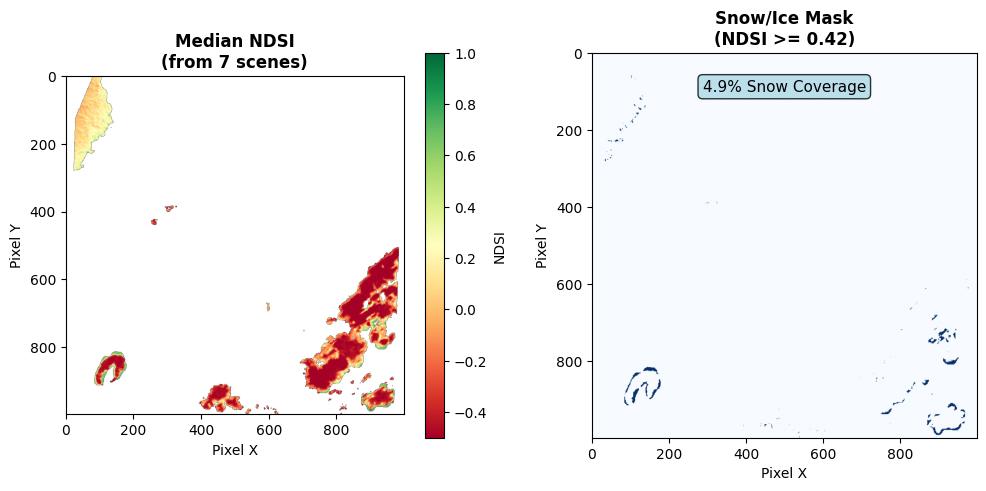

In [70]:
# ======================================================================
# Visualization: NDSI and Snow/Ice Classification Results
# ======================================================================
# Creates a 2-panel diagnostic plot:
# 1. Median NDSI map (spectral snow index)
# 2. Binary snow/ice mask (pixels where NDSI >= threshold)

if result:
    # Create visualization of NDSI and snow mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Median NDSI
    im1 = axes[0].imshow(result['ndsi_median'].values, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0].set_title(f'Median NDSI\n(from {result["scene_count"]} scenes)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Pixel X')
    axes[0].set_ylabel('Pixel Y')
    plt.colorbar(im1, ax=axes[0], label='NDSI')
    
    # Plot 2: Snow/Ice Mask
    axes[1].imshow(result['snow_mask'].values, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # Add percentage annotation
    axes[1].text(0.5, 0.9, f'{result["snow_percentage"]:.1f}% Snow Coverage', 
                 transform=axes[1].transAxes, ha='center', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
else:
    print("No results to visualize.")

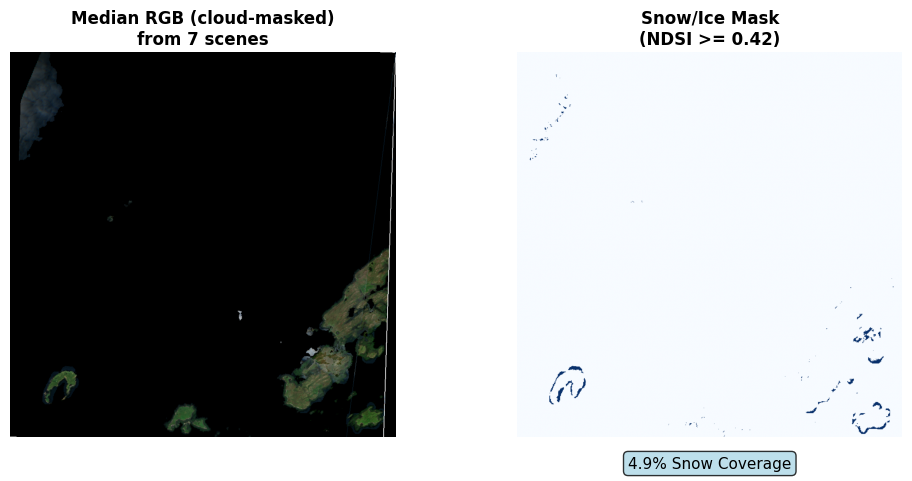

In [71]:
# ======================================================================
# Visualization: Median RGB vs Snow/Ice Mask
# ======================================================================
if result and rgb_result:
    rgb_da = rgb_result['rgb_median']
    rgb_np = np.stack([
        rgb_da.sel(band="R").values,
        rgb_da.sel(band="G").values,
        rgb_da.sel(band="B").values
    ], axis=-1)

    valid_vals = rgb_np[np.isfinite(rgb_np)]
    if valid_vals.size == 0:
        print("RGB composite is empty after masking")
    else:
        low, high = np.nanpercentile(valid_vals, [2, 98])
        rgb_stretched = (rgb_np - low) / (high - low + 1e-6)
        rgb_stretched = np.clip(rgb_stretched, 0, 1)
        rgb_stretched = np.nan_to_num(rgb_stretched, nan=0.0)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(rgb_stretched)
        axes[0].set_title(f"Median RGB (cloud-masked)\nfrom {rgb_result['scene_count']} scenes", fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(result['snow_mask'].values, cmap='Blues', vmin=0, vmax=1)
        axes[1].set_title(f"Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})", fontsize=12, fontweight='bold')
        axes[1].axis('off')
        axes[1].text(0.5, -0.08, f"{result['snow_percentage']:.1f}% Snow Coverage",
                     transform=axes[1].transAxes, ha='center', fontsize=11,
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
else:
    print("RGB or NDSI result missing; run previous cell first.")

#### 3.2.7 Step 6 & 7: Spatial Expansion and Complete Algorithm

**Goal**: Implement spatial expansion and combine all steps into a complete glacier monitoring algorithm.

**Spatial Expansion Logic**:
- If a candidate cell has >30% snow coverage, its 4 direct neighbors (N, S, E, W) become candidates
- Only unprocessed cells are added to avoid infinite loops
- Process continues until no new candidates are added

**Complete Algorithm**:
1. Load seeds and create grid with initial candidates (cells containing seeds)
2. **Iteration loop**:
   - Process each unprocessed candidate cell:
     - Query STAC for Sentinel-2 scenes
     - Compute median NDSI
     - Apply spatial expansion if >30% snow coverage
     - Add neighbors as new candidates
   - Mark cell as processed
   - Continue until no new candidates remain
3. Combine all NDSI results into single ISN2004 grid
4. Generate statistics and final snow/ice mask

In [72]:
def get_neighbor_cells(cell_id, grid):
    """
    Get the 4 direct neighbors (N, S, E, W) of a grid cell.
    
    Parameters:
    -----------
    cell_id : int
        ID of the cell to get neighbors for
    grid : gpd.GeoDataFrame
        Grid with all cells
    
    Returns:
    --------
    list : List of neighbor cell IDs that exist in the grid
    """
    cell = grid[grid['cell_id'] == cell_id].iloc[0]
    cell_geom = cell.geometry
    centroid = cell_geom.centroid
    
    # Calculate neighbor positions (10 km grid)
    neighbors = []
    offsets = [
        (0, GRID_SIZE),   # North
        (0, -GRID_SIZE),  # South
        (GRID_SIZE, 0),   # East
        (-GRID_SIZE, 0)   # West
    ]
    
    for dx, dy in offsets:
        neighbor_point = Point(centroid.x + dx, centroid.y + dy)
        # Find cell that contains this point
        matching_cells = grid[grid.contains(neighbor_point)]
        if len(matching_cells) > 0:
            neighbors.append(matching_cells.iloc[0]['cell_id'])
    
    return neighbors


def apply_spatial_expansion(grid, cell_id, snow_percentage, threshold=0.30):
    """
    Apply spatial expansion: if snow coverage exceeds threshold,
    mark all unprocessed neighbors as candidates.
    
    Parameters:
    -----------
    grid : gpd.GeoDataFrame
        Grid with cells and their status
    cell_id : int
        ID of the cell to expand from
    snow_percentage : float
        Snow coverage percentage (0-100)
    threshold : float
        Threshold for expansion (default 0.30 = 30%)
    
    Returns:
    --------
    int : Number of new candidates added
    """
    if snow_percentage / 100.0 < threshold:
        return 0
    
    neighbors = get_neighbor_cells(cell_id, grid)
    new_candidates = 0
    
    for neighbor_id in neighbors:
        neighbor = grid.loc[grid['cell_id'] == neighbor_id]
        if len(neighbor) > 0:
            # Only add if not already a candidate and not yet processed
            if not neighbor.iloc[0]['is_candidate'] and not neighbor.iloc[0].get('is_processed', False):
                grid.loc[grid['cell_id'] == neighbor_id, 'is_candidate'] = True
                new_candidates += 1
    
    return new_candidates

In [ ]:
def run_glacier_monitoring(seeds, grid_bounds, grid_size, epsg_code, 
                          date_start, date_end, stac_url,
                          ndsi_threshold, snow_threshold, max_scenes=100):
    """
    Complete glacier monitoring algorithm with spatial expansion.
    
    Executes steps 1-7 of the algorithm:
    1. Create grid and mark initial candidates
    2. Iterate: Process candidates, compute NDSI, apply spatial expansion
    3. Combine results into single snow/ice mask
    
    Parameters:
    -----------
    seeds : gpd.GeoDataFrame
        Glacier seed points in ISN2004
    grid_bounds : list
        [minx, miny, maxx, maxy] for grid creation
    grid_size : int
        Grid cell size in meters
    epsg_code : int
        EPSG code for Iceland projection
    date_start, date_end : str
        Time period for Sentinel-2 data
    stac_url : str
        STAC catalog URL
    ndsi_threshold : float
        NDSI threshold for snow/ice classification
    snow_threshold : float
        Snow coverage threshold for spatial expansion (0-1)
    max_scenes : int
        Maximum scenes to process per cell
    
    Returns:
    --------
    dict : Results containing:
        - 'ndsi_combined': xr.DataArray with combined NDSI grid
        - 'snow_mask_combined': xr.DataArray with final snow/ice mask
        - 'grid': gpd.GeoDataFrame with processed cells
        - 'statistics': dict with processing statistics
    """
    print("=" * 80)
    print("GLACIER MONITORING ALGORITHM - SPATIAL EXPANSION")
    print("=" * 80)
    
    # Step 1: Create grid and mark initial candidates
    print("\n[Step 1] Creating grid and marking initial candidates...")
    grid = create_grid(grid_bounds, grid_size)
    grid = mark_candidate_cells(grid, seeds)
    grid['is_processed'] = False
    grid['snow_percentage'] = None
    
    initial_candidates = grid['is_candidate'].sum()
    print(f"   Initial candidates (cells with seeds): {initial_candidates}")
    
    # Prepare result storage
    ndsi_results = {}  # cell_id -> ndsi_array
    cell_bounds_dict = {}  # cell_id -> bounds
    
    # Step 2: Iteration loop with spatial expansion
    iteration = 0
    total_processed = 0
    total_expansion_adds = 0
    
    while True:
        iteration += 1
        # Get unprocessed candidates
        unprocessed = grid[(grid['is_candidate']) & (~grid['is_processed'])]
        
        if len(unprocessed) == 0:
            print(f"\n[Iteration {iteration}] No more candidates to process. Algorithm complete!")
            break
        
        if iteration > MAX_ITERATIONS:
            print(f"\n[Iteration {iteration}] Reached maximum iterations ({MAX_ITERATIONS}). Stopping.")
            break
        
        print(f"\n[Iteration {iteration}] Processing {len(unprocessed)} candidate cells...")
        
        iteration_adds = 0
        cells_with_snow = 0
        
        for idx, cell_row in unprocessed.iterrows():
            cell_id = cell_row['cell_id']
            cell_geom = cell_row.geometry
            cell_bounds = cell_geom.bounds
            
            print(f"  Cell {cell_id} (seed_count={cell_row.get('seed_count', 0)})...", end=" ")
            
            # Query STAC for this cell
            items = query_stac_for_cell(
                cell=cell_row,
                date_start=date_start,
                date_end=date_end,
                epsg_code=epsg_code,
                stac_url=stac_url,
                verbose=False
            )
            
            if len(items) == 0:
                print("no scenes found, skipped")
                grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
                continue
            
            # Compute NDSI for this cell
            result = compute_median_ndsi_for_cell(
                stac_items=items,
                cell_bounds=cell_bounds,
                epsg_code=epsg_code,
                max_scenes=max_scenes
            )
            
            if result is None:
                print("   NDSI computation failed")
                grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
                continue
            
            # Store result
            ndsi_results[cell_id] = result['ndsi_median']
            cell_bounds_dict[cell_id] = cell_bounds
            snow_pct = result['snow_percentage']
            
            # Add results to grid
            grid.loc[grid['cell_id'] == cell_id, 'snow_percentage'] = snow_pct
            
            print(f"   Snow coverage: {snow_pct:.1f}%")
            
            # Apply spatial expansion
            if snow_pct > 0:
                cells_with_snow += 1
                new_adds = apply_spatial_expansion(
                    grid, cell_id, snow_pct, threshold=snow_threshold
                )
                if new_adds > 0:
                    print(f"   → Added {new_adds} neighbors as candidates")
                    iteration_adds += new_adds
            
            # Mark as processed
            grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
            total_processed += 1
        
        total_expansion_adds += iteration_adds
        print(f"   Iteration summary: {len(unprocessed)} processed, {cells_with_snow} with snow, {iteration_adds} new candidates added")
    
    # Step 3: Combine all NDSI results into single grid
    print(f"\n[Step 3] Combining {len(ndsi_results)} NDSI results into unified grid...")
    
    if len(ndsi_results) == 0:
        print("ERROR: No valid NDSI results to combine!")
        return None
    
    # Determine combined grid extent
    all_bounds = list(cell_bounds_dict.values())
    global_minx = min(b[0] for b in all_bounds)
    global_miny = min(b[1] for b in all_bounds)
    global_maxx = max(b[2] for b in all_bounds)
    global_maxy = max(b[3] for b in all_bounds)
    
    # Create combined grid (10m resolution)
    combined_x = np.arange(global_minx, global_maxx, 10)
    combined_y = np.arange(global_miny, global_maxy, 10)
    combined_ndsi = np.full((len(combined_y), len(combined_x)), np.nan, dtype=float)
    
    # Fill in NDSI values from each cell
    for cell_id, ndsi_array in ndsi_results.items():
        bounds = cell_bounds_dict[cell_id]
        minx, miny, maxx, maxy = bounds
        
        # Find indices in combined grid
        x_start = int((minx - global_minx) / 10)
        x_end = int((maxx - global_minx) / 10)
        y_start = int((miny - global_miny) / 10)
        y_end = int((maxy - global_miny) / 10)
        
        # Insert NDSI values
        ndsi_values = ndsi_array.values
        combined_ndsi[y_start:y_end, x_start:x_end] = ndsi_values
    
    # Create xarray DataArray
    ndsi_combined = xr.DataArray(
        combined_ndsi,
        dims=['y', 'x'],
        coords={'x': combined_x, 'y': combined_y},
        attrs={
            'crs': f'EPSG:{epsg_code}',
            'description': 'Combined median NDSI from all processed cells',
            'algorithm': 'Zarr-optimized glacier monitoring with spatial expansion'
        }
    )
    
    # Create final snow/ice mask
    snow_mask_combined = ndsi_combined >= ndsi_threshold
    
    # Calculate statistics
    valid_pixels = np.sum(~np.isnan(combined_ndsi))
    snow_pixels = np.sum(snow_mask_combined.values)
    snow_area_km2 = (snow_pixels * 10 * 10) / 1e6  # 10m pixels to km²
    total_area_km2 = (valid_pixels * 10 * 10) / 1e6
    
    statistics = {
        'total_cells_processed': total_processed,
        'initial_candidates': initial_candidates,
        'expansion_added_cells': total_expansion_adds,
        'iterations': iteration,
        'valid_pixels': int(valid_pixels),
        'snow_ice_pixels': int(snow_pixels),
        'snow_ice_coverage_km2': snow_area_km2,
        'total_valid_area_km2': total_area_km2,
        'snow_ice_percentage': 100.0 * snow_pixels / valid_pixels if valid_pixels > 0 else 0
    }
    
    # Print final statistics
    print("\n" + "=" * 80)
    print("ALGORITHM COMPLETED - FINAL STATISTICS")
    print("=" * 80)
    print(f"Total cells processed:        {statistics['total_cells_processed']}")
    print(f"  - Initial candidates:       {statistics['initial_candidates']}")
    print(f"  - Added by expansion:       {statistics['expansion_added_cells']}")
    print(f"Total iterations:             {statistics['iterations']}")
    print(f"Valid pixels analyzed:        {statistics['valid_pixels']:,}")
    print(f"Snow/Ice pixels detected:     {statistics['snow_ice_pixels']:,}")
    print(f"Snow/Ice area:                {statistics['snow_ice_coverage_km2']:.2f} km²")
    print(f"Total analyzed area:          {statistics['total_valid_area_km2']:.2f} km²")
    print(f"Snow/Ice coverage:            {statistics['snow_ice_percentage']:.2f}%")
    print("=" * 80)
    
    return {
        'ndsi_combined': ndsi_combined,
        'snow_mask_combined': snow_mask_combined,
        'grid': grid,
        'statistics': statistics
    }

In [74]:
# ======================================================================
# Execute Complete Glacier Monitoring Algorithm
# ======================================================================

# Run the complete algorithm with spatial expansion
final_result = run_glacier_monitoring(
    seeds=seeds,
    grid_bounds=BOUNDING_BOX_ICELAND,
    grid_size=GRID_SIZE,
    epsg_code=EPSG_ICELAND,
    date_start=DATE_START,
    date_end=DATE_END,
    stac_url=STAC_URL,
    ndsi_threshold=NDSI_THRESHOLD,
    snow_threshold=SNOW_PERCENTAGE_THRESHOLD,
    max_scenes=100
)

if final_result:
    print("\n✓ Algorithm completed successfully!")
    print(f"✓ Combined NDSI grid shape: {final_result['ndsi_combined'].shape}")
    print(f"✓ Snow/Ice mask created with {final_result['statistics']['snow_ice_pixels']:,} pixels")
else:
    print("\n✗ Algorithm failed!")

GLACIER MONITORING ALGORITHM - SPATIAL EXPANSION

[Step 1] Creating grid and marking initial candidates...
   Initial candidates (cells with seeds): 87

[Iteration 1] Processing 87 candidate cells...
  Cell 267 (seed_count=3)... 
Processing up to 100 scenes from 13 available...
  [1/13] S2C_MSIL2A_20250729T125321_N05... loaded, reprojected to ISN2004
  [2/13] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [3/13] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T60VXR_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [4/13] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T01VCL_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [5/13] S2B_MSIL2A_20250713T232639_N05...   Error loading S2B_MSIL2A_20250713T232639_N0511_R130_T60VXR_20250713T234845.zarr: No group foun

ValueError: Must have equal len keys and value when setting with an ndarray

In [ ]:
# ======================================================================
# Visualization: Final Results (Interactive Folium Map)
# ======================================================================
# Shows processed grid cells with color-coded snow coverage
# Similar to the Grid visualization from Step 2, but with processed cells

if final_result:
    processed_grid = final_result['grid'][final_result['grid']['is_processed']].copy()
    
    # Separate initial cells (with seeds) from expansion cells
    initial_cells_gdf = processed_grid[processed_grid['seed_count'] > 0]
    expansion_cells_gdf = processed_grid[processed_grid['seed_count'] == 0]
    
    # Additional statistics
    print(f"\nProcessed cells by origin:")
    print(f"  Initial (with seeds): {len(initial_cells_gdf)}")
    print(f"  Added by expansion:   {len(expansion_cells_gdf)}")
    
    # Transform to WGS84 for web mapping (folium requires WGS84)
    processed_grid_wgs84 = processed_grid.to_crs(epsg=4326)
    initial_cells_wgs84 = initial_cells_gdf.to_crs(epsg=4326)
    expansion_cells_wgs84 = expansion_cells_gdf.to_crs(epsg=4326)
    seeds_wgs84 = seeds.to_crs(epsg=4326)
    
    # Calculate center for map
    center_lat = processed_grid_wgs84.geometry.centroid.y.mean()
    center_lon = processed_grid_wgs84.geometry.centroid.x.mean()
    
    # Create interactive map with satellite imagery
    map_results = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=7,
        tiles=None
    )
    
    # Add Esri World Imagery
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri World Imagery',
        name='Satellite Imagery',
        overlay=False,
        control=True
    ).add_to(map_results)
    
    # Add initial cells (with seeds) in blue
    if len(initial_cells_wgs84) > 0:
        folium.GeoJson(
            initial_cells_wgs84[['cell_id', 'seed_count', 'snow_percentage', 'geometry']],
            name='Initial Cells (with seeds)',
            style_function=lambda x: {
                'fillColor': 'blue',
                'color': 'darkblue',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'seed_count', 'snow_percentage'],
                aliases=['Cell ID:', 'Seeds:', 'Snow Coverage'],
                localize=True
            ),
            popup=folium.GeoJsonPopup(
                fields=['cell_id', 'seed_count', 'snow_percentage'],
                aliases=['Cell ID:', 'Number of Seeds:', 'Snow Coverage']
            )
        ).add_to(map_results)
    
    # Add expansion cells (no seeds) in green
    if len(expansion_cells_wgs84) > 0:
        folium.GeoJson(
            expansion_cells_wgs84[['cell_id', 'snow_percentage', 'geometry']],
            name='Expansion Cells',
            style_function=lambda x: {
                'fillColor': 'lightgreen',
                'color': 'green',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'snow_percentage'],
                aliases=['Cell ID:', 'Snow Coverage'],
                localize=True
            ),
            popup=folium.GeoJsonPopup(
                fields=['cell_id', 'snow_percentage'],
                aliases=['Cell ID (expansion):', 'Snow Coverage']
            )
        ).add_to(map_results)
    
    # Add seed points as feature group
    seed_group = folium.FeatureGroup(name='Glacier Seeds')
    for idx, row in seeds_wgs84.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.7,
            popup=f"<b>Seed {idx}</b>",
            tooltip="Glacier Seed"
        ).add_to(seed_group)
    
    seed_group.add_to(map_results)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(map_results)
    
    # Add layer control (allows toggling layers on/off)
    folium.LayerControl(collapsed=False).add_to(map_results)
    
    # Print summary statistics
    print(f"\n✓ Interactive map created with {len(processed_grid)} processed cells")
    print(f"  Blue cells: Initial candidates (with seeds) - {len(initial_cells_wgs84)}")
    print(f"  Green cells: Added by spatial expansion - {len(expansion_cells_wgs84)}")
    print(f"  Total snow/ice coverage: {final_result['statistics']['snow_ice_coverage_km2']:.0f} km²")
    print(f"\nTip: Use the layer control in the top right to toggle layers on/off")
    
    # Display map (must be last expression in cell to render)
    display(map_results)
else:
    print("No results to visualize.")


Processed cells by origin:
  Initial (with seeds): 87
  Added by expansion:   783

✓ Interactive map created with 870 processed cells
  Blue cells: Initial candidates (with seeds) - 87
  Green cells: Added by spatial expansion - 783
  Total snow/ice coverage: 27778 km²

Tip: Use the layer control in the top right to toggle layers on/off


In [18]:
# ======================================================================
# Visualization: Final Results
# ======================================================================

if final_result:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Combined NDSI
    im1 = axes[0].imshow(
        final_result['ndsi_combined'].values,
        cmap='RdYlGn',
        vmin=-0.5,
        vmax=1.0,
        extent=[
            final_result['ndsi_combined'].x.min(),
            final_result['ndsi_combined'].x.max(),
            final_result['ndsi_combined'].y.min(),
            final_result['ndsi_combined'].y.max()
        ]
    )
    axes[0].set_title(
        f"Combined NDSI Map\n({final_result['statistics']['total_cells_processed']} cells processed)",
        fontsize=13,
        fontweight='bold'
    )
    axes[0].set_xlabel('X (ISN2004) [m]')
    axes[0].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im1, ax=axes[0], label='NDSI', fraction=0.046)
    
    # Plot 2: Final Snow/Ice Mask
    im2 = axes[1].imshow(
        final_result['snow_mask_combined'].values,
        cmap='Blues',
        vmin=0,
        vmax=1,
        extent=[
            final_result['snow_mask_combined'].x.min(),
            final_result['snow_mask_combined'].x.max(),
            final_result['snow_mask_combined'].y.min(),
            final_result['snow_mask_combined'].y.max()
        ]
    )
    axes[1].set_title(
        f"Final Snow/Ice Mask\n({final_result['statistics']['snow_ice_coverage_km2']:.0f} km²)",
        fontsize=13,
        fontweight='bold'
    )
    axes[1].set_xlabel('X (ISN2004) [m]')
    axes[1].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im2, ax=axes[1], label='Snow/Ice', fraction=0.046, ticks=[0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics plot
    processed_grid = final_result['grid'][final_result['grid']['is_processed']]
    print(f"\nProcessed cells by origin:")
    print(f"  Initial (with seeds): {(processed_grid['seed_count'] > 0).sum()}")
    print(f"  Added by expansion:   {(processed_grid['seed_count'] == 0).sum()}")
else:
    print("No results to visualize.")

MemoryError: Unable to allocate 2.12 GiB for an array with shape (40000, 57000) and data type bool

Error in callback <function _draw_all_if_interactive at 0x000002B76242D3A0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 17.0 GiB for an array with shape (40000, 57000) and data type float64

MemoryError: Unable to allocate 17.0 GiB for an array with shape (40000, 57000) and data type float64

<Figure size 1600x700 with 3 Axes>

Creating downsampled visualization (factor: 20)...


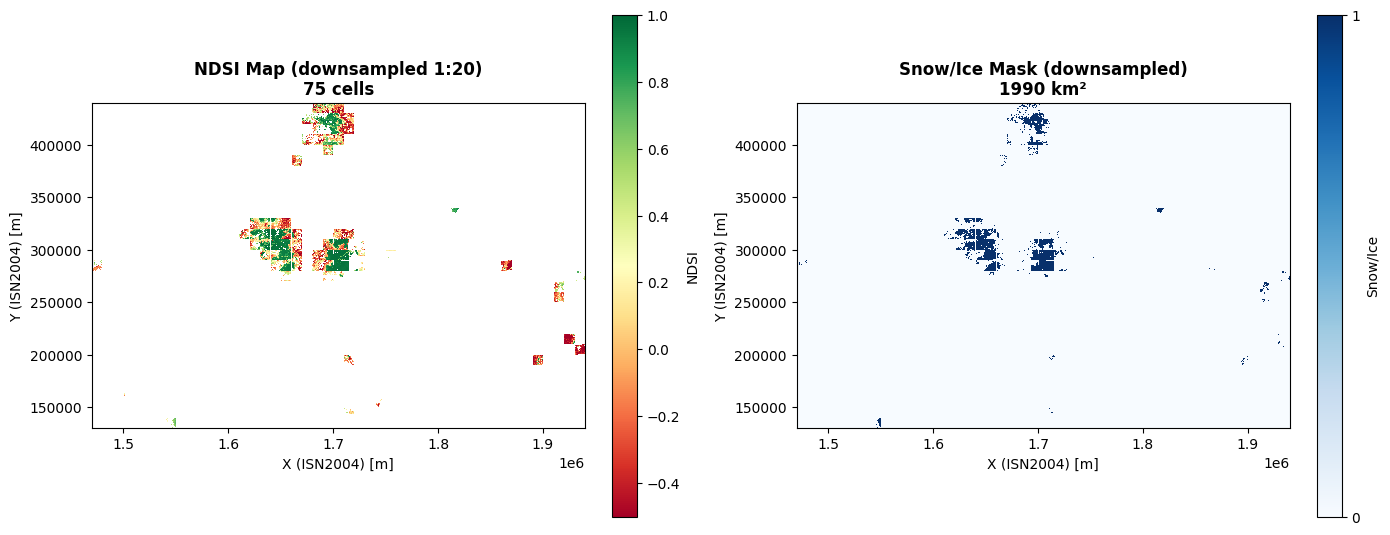

✓ Downsampled plots created
  Original size: (31000, 47000)
  Downsampled size: (1550, 2350)
  Memory reduction: ~400x


In [ ]:
# ======================================================================
# Optional: Downsampled NDSI/Snow Mask Visualization
# ======================================================================
# Only use this if you want to see the NDSI data (uses downsampling to save RAM)

if final_result:
    # Downsample factor (e.g., 10 = every 10th pixel)
    downsample_factor = 20  # Adjust this if still too much RAM
    
    print(f"Creating downsampled visualization (factor: {downsample_factor})...")
    
    # Downsample the data
    ndsi_downsampled = final_result['ndsi_combined'].values[::downsample_factor, ::downsample_factor]
    snow_downsampled = final_result['snow_mask_combined'].values[::downsample_factor, ::downsample_factor]
    
    # Create downsampled coordinates
    x_down = final_result['ndsi_combined'].x.values[::downsample_factor]
    y_down = final_result['ndsi_combined'].y.values[::downsample_factor]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Downsampled NDSI
    im1 = axes[0].imshow(
        ndsi_downsampled,
        cmap='RdYlGn',
        vmin=-0.5,
        vmax=1.0,
        extent=[x_down.min(), x_down.max(), y_down.min(), y_down.max()],
        interpolation='nearest'
    )
    axes[0].set_title(
        f"NDSI Map (downsampled 1:{downsample_factor})\n{final_result['statistics']['total_cells_processed']} cells",
        fontsize=12,
        fontweight='bold'
    )
    axes[0].set_xlabel('X (ISN2004) [m]')
    axes[0].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im1, ax=axes[0], label='NDSI', fraction=0.046)
    
    # Plot 2: Downsampled Snow Mask
    im2 = axes[1].imshow(
        snow_downsampled,
        cmap='Blues',
        vmin=0,
        vmax=1,
        extent=[x_down.min(), x_down.max(), y_down.min(), y_down.max()],
        interpolation='nearest'
    )
    axes[1].set_title(
        f"Snow/Ice Mask (downsampled)\n{final_result['statistics']['snow_ice_coverage_km2']:.0f} km²",
        fontsize=12,
        fontweight='bold'
    )
    axes[1].set_xlabel('X (ISN2004) [m]')
    axes[1].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im2, ax=axes[1], label='Snow/Ice', fraction=0.046, ticks=[0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Downsampled plots created")
    print(f"  Original size: {final_result['ndsi_combined'].shape}")
    print(f"  Downsampled size: {ndsi_downsampled.shape}")
    print(f"  Memory reduction: ~{downsample_factor**2}x")
else:
    print("No results to visualize.")